This tutorial is based on the textbook here: https://lukas-snoek.com/NI-edu/fMRI-introduction/week_2/glm_part1_estimation.html

## GLM in fMRI analyses - Sigrid
Univariate fMRI analyses basically use the same linear regression model as we've explained above to model the activation of voxels (with some minor additions) based on some design-matrix.

### The target
However, compared to "regular" data, one major difference is that *the dependent variable ($y$) in fMRI analyses is timeseries data*, which means that the observations of the dependent variable (activation of voxels) vary across time. 

How does such a time-series data look like? Let's look at a (simulated) time-series from a single voxel:

In [1]:
# First some imports
# importing modules
import os
import pip
os.system('python3 -m pip install numpy')
os.system('python3 -m pip install matplotlib')
os.system('python3 -m pip install scipy')
os.system('python3 -m pip install nilearn')

import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 44.8 MB/s eta 0:00:00

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


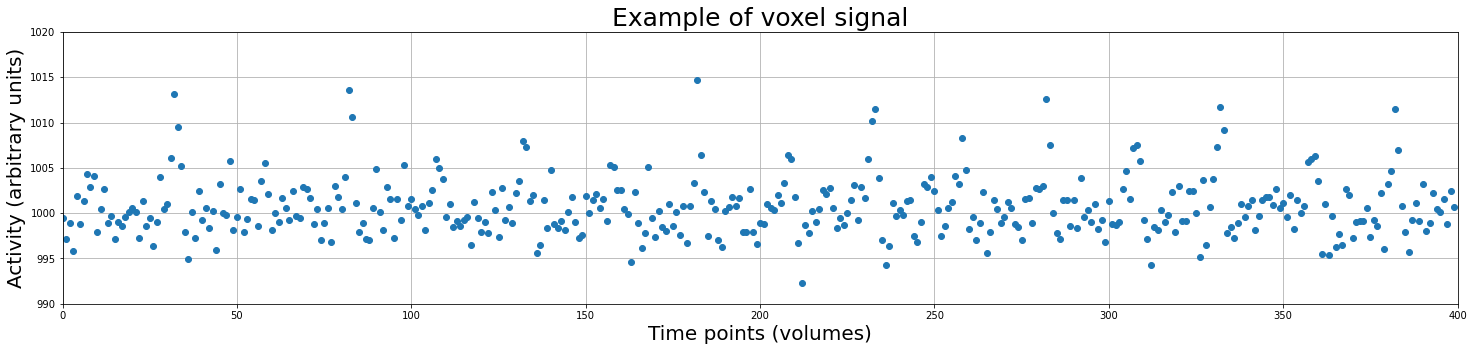

In [2]:
voxel_signal = np.load('data/example_voxel_signal.npy')
plt.figure(figsize=(25, 5))
plt.plot(voxel_signal, 'o')
plt.xlabel('Time points (volumes)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
x_lim, y_lim = (0, 400), (990, 1020)
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.title('Example of voxel signal', fontsize=25)
plt.grid()
plt.show()


So, the voxel timeseries (i.e. activation over time; often called 'signal') is our dependent variable ($y$). Thus, the different time points (with corresponding activity values) make up our observations/samples!

<div class='alert alert-info'>
<b>ToThink1</b> : Suppose that the TR ("time to repetition", i.e. how long it takes to measure each volume) of our acquisition was 2 seconds, can you deduce the duration of the experiment (in seconds) from the plot above?

Hint: You can also use voxel_signal.shape
    
(Solution at the end)
</div>

WRITE YOUR ANSWERE HERE:

So, in the plot above, the data points represent the activity (in arbitrary units) of a single voxel across time (measured in volumes). This visualization of the time-series data as discrete measurements is not really intuitive. Usually, we plot the data as continuous line over time (but always remember: fMRI data is a discretely sampled signal -- *not* a continuous one). Let's plot it as a line:

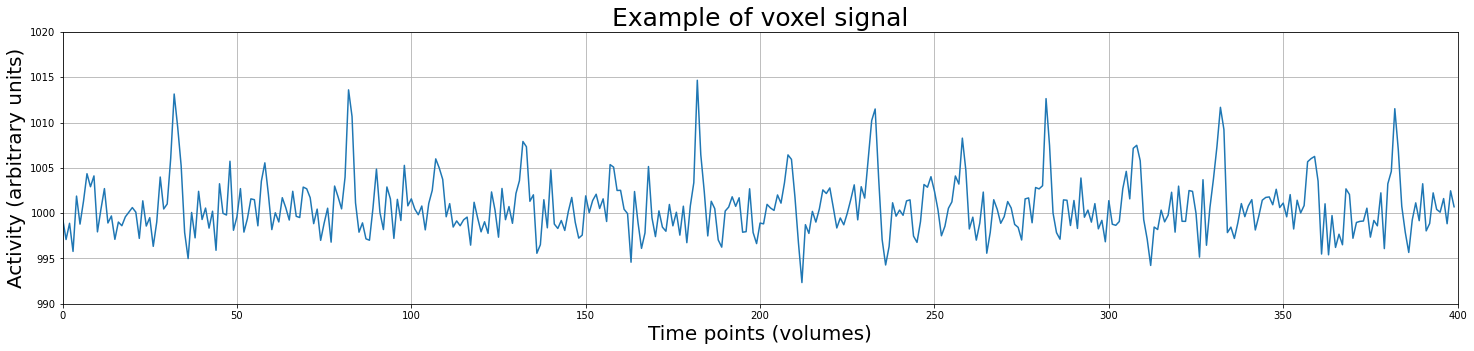

In [3]:
plt.figure(figsize=(25, 5))
plt.plot(voxel_signal)
plt.xlabel('Time points (volumes)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.title('Example of voxel signal', fontsize=25)
plt.grid()
plt.show()

Alright, this looks better. Now, let's look at our potential predictors ($X$).

### The predictors, or: what should we use to model our target?

#### Defining independent variables
So, we know what our target is (the time-series data), but what do we use to model/explain our signal? Well, in most neuroimaging research, your predictors are defined by your experimental design! In other words, your predictors consist of *whatever you think influenced your signal*.

This probably sounds nonsensical, which is likely caused by the fact that we derive our independent variables (predictors) in most (observational) psychological research differently. This is because in (observational) psychological studies *both the independent variables and the dependent variables are __measured__*. In other words, our predictors are just other variables that you measured in your study. 

In neuroimaging research, however, we often derive our predictors not from measures variables but from properties of the particular experiment that we use in the MRI-scanner (or during EEG/MEG acquisiton, for that matter). In other words, we can use any property of the experiment that we believe explains our signal.

Alright, probably still sounds vague. Let's imagine a (hypothetical) experiment in which we show subjects images of either circles or squares during fMRI acquisition lasting 800 seconds, as depicted in the image below:

![img](https://docs.google.com/drawings/d/e/2PACX-1vQwC4chpnzsDEzKhrKH_WHhMX7vJswY4H0pkyIxdlxI_I2GG5e8i6lsiWUO0SUk7NBgdV-vXD5PIleJ/pub?w=950&h=397)

Note that the interstimulus interval (ISI, i.e., the time between consecutive stimuli) of 50 seconds, here, is quite unrealistic; often, fMRI experiments have a much shorter ISI (e.g., around 3 seconds). Here, we will use an hypothetical experiment with an ISI of 50 seconds because that simplifies things a bit and will make figures easier to interpret.

Anyway, let's talk about what predictors we could use given our experimental paradigm. One straighforward suggestion about properties that influence our signal is that our signal is influenced by the stimuli we show the participant during the experiment. As such, we could construct a predictor that predicts some response in the signal when a stimulus (here: a square or a circle) is present, and no response when a stimulus is absent.

Fortunately, we kept track of the onsets (in seconds!) of our stimuli during the experiment:

In [4]:
onsets_squares = np.array([10, 110, 210, 310, 410, 510, 610, 710], dtype=int)
onsets_circles = np.array([60, 160, 260, 360, 460, 560, 660, 760], dtype=int)

In other words, the first circle-stimulus was presented at 60 seconds after the scan started and the last square-stimulus was presented 710 seconds after the can started.

For now, we'll ignore the difference between square-stimuli and circle-stimuli by creating a predictor that lumps the onsets of these two types of stimuli together in one array. This predictor thus reflects the hypothesis that the signal is affected by the presence of a stimulus (regardless of whether this was a square or a circle). (Later in the tutorial, we'll explain how to *compare* the effects of different conditions.)

We'll call this predictor simply `onsets_all`:

In [5]:
onsets_all = np.concatenate((onsets_squares, onsets_circles))
print(onsets_all)

[ 10 110 210 310 410 510 610 710  60 160 260 360 460 560 660 760]


Now, we need to do one last thing: convert the `onsets_all` vector into a proper predictor. Right now, the variable contains only the onsets, but a predictor should be an array with the same shape as the target.

Given that our predictor should represent the hypothesis that the signal responds to the presence of a stimulus (and doesn't respond when a stimulus is absent), we can construct our predictor as a vector of all zeros, except at indices corresponding to the onsets of our stimuli, where the value is 1.

We do this below:

In [6]:
predictor_all = np.zeros(800)  # because the experiment lasted 800 seconds
predictor_all[onsets_all] = 1  # set the predictor at the indices to 1

print("Shape of predictor: %s" % (predictor_all.shape,))
print("\nContents of our predictor array:\n%r" % predictor_all.T)

Shape of predictor: (800,)

Contents of our predictor array:
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 

We can even plot it in a similar way as we did with the voxel signal:

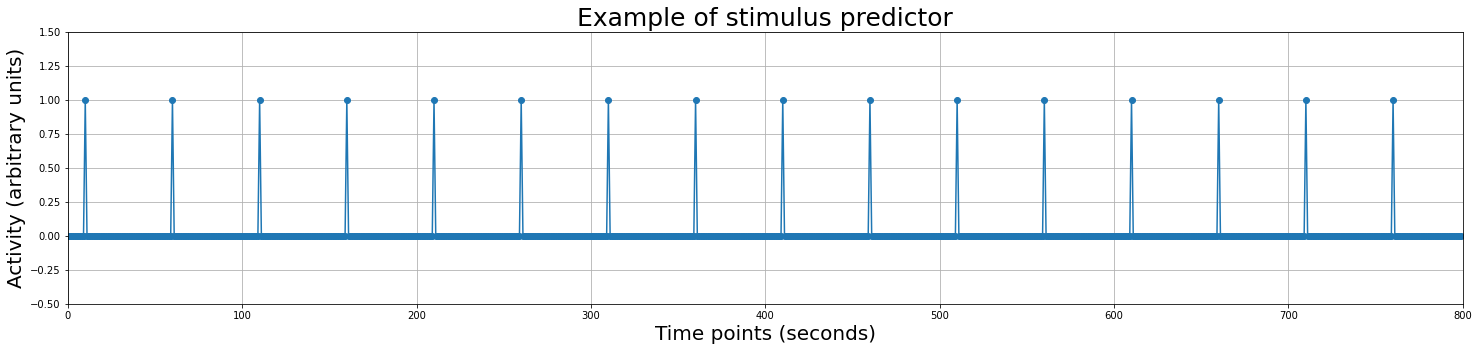

In [7]:
plt.figure(figsize=(25, 5))
plt.plot(predictor_all, marker='o')
plt.xlabel('Time points (seconds)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
plt.xlim(0, 800)
plt.ylim(-.5, 1.5)
plt.title('Example of stimulus predictor', fontsize=25)
plt.grid()
plt.show()

#### Resampling
However, if you look back at the plot of the voxel signal, you might notice that there is a problem in our stimulus-predictor - it seems to be on a different timescale than the signal. And that's true! The signal from the voxel is measured in volumes (in total 400, with a TR of 2 seconds) while the stimulus-onsets are defined in seconds (ranging from 10 to 760)!

This "issue" can be solved by downsampling our predictor to the time resolution of our signal, i.e., one datapoint every two seconds (given that our TR is 2 seconds). In the plot below, we show you with dashed red lines which datapoints would constitute our predictor *after* downsampling (we only show the first 100 seconds for clarity).

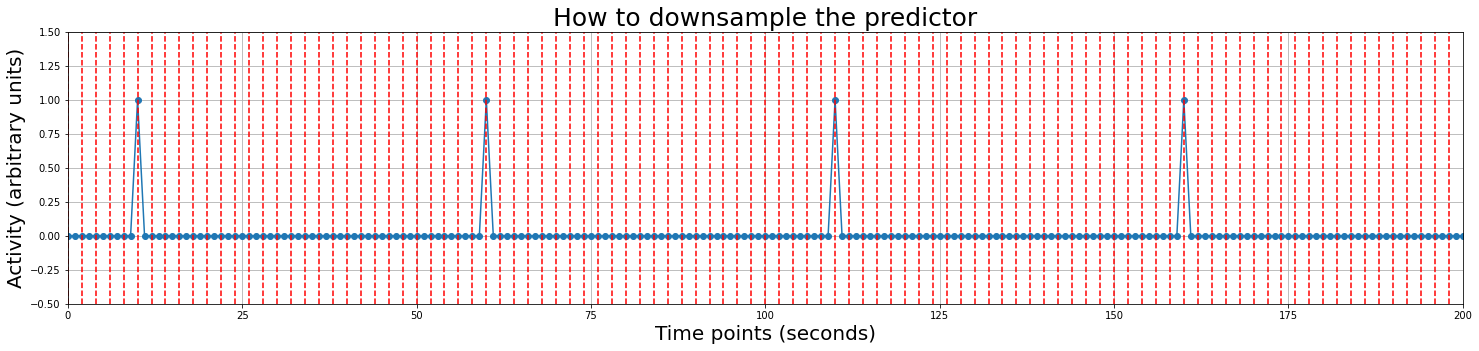

In [8]:
plt.figure(figsize=(25, 5))
plt.plot(predictor_all, marker='o')
plt.xlabel('Time points (seconds)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
plt.xlim(0, 200)
plt.ylim(-.5, 1.5)
plt.title('How to downsample the predictor', fontsize=25)
plt.grid()

for t in np.arange(0, 200, 2):
    plt.axvline(t, ls='--', c='r')

plt.show()

Resampling in Python can be done using the `interp1d` function from the `scipy.interpolate` package. It works by first creating a mapping between the *scale* of the original array and the *values* of the original array, and then converting the original array to a *different scale*. We'll show you how this would be done with our `predictor_all` array. 

```python
resampler = interp1d(original_scale, original_array, kind='linear')  # interp1d returns a (new) function
downsampled_array = resampler(desired_scale) 
```

Note that when creating the mapping by calling `interp1d`, the function returns a *new function*, which we store in a variable called `resampler`. Now, we can call with new function with our desired scale for our array, which will result the original array downsampled at the desired scale (note that this works exactly the same for *up*sampling). Also note that we we use specifically "linear" resampling (by using `kind='linear'`). In practice, most neuroimaging packages use non-linear resampling/interpolation when downsampling predictors, but the details of different kinds of resampling are beyond the scope of this course. 

Anyway, let's try this on our predictor by resampling it from the original scale (0-800 seconds) to the scale of our signal (i.e., at 0, 2, 4, 8 ... 800 seconds, assuming a TR of 2 seconds). Note the function `np.arange`, which can be used to create evenly spaced arrays (with `np.arange(start, stop, step)`):

In [9]:
from scipy.interpolate import interp1d
original_scale = np.arange(0, 800, 1)  # from 0 to 800 seconds
print("Original scale has %i datapoints (0-800, in seconds)" % original_scale.size)
resampler = interp1d(original_scale, predictor_all)

desired_scale = np.arange(0, 800, 2)
print("Desired scale has %i datapoints (0, 2, 4, ... 800, in volumes)" % desired_scale.size)
predictor_all_ds = resampler(desired_scale)

print("Downsampled predictor has %i datapoints (in volumes)" % predictor_all_ds.size)

Original scale has 800 datapoints (0-800, in seconds)
Desired scale has 400 datapoints (0, 2, 4, ... 800, in volumes)
Downsampled predictor has 400 datapoints (in volumes)


That seemed to have worked! Let's print it to be sure:

In [10]:
print(predictor_all_ds)

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

Awesome! Now, we have a predictor ($X$) and a target ($y$) of the same shape, so we can apply linear regression! But before we do this, let's plot the predictor and the signal in the same plot:

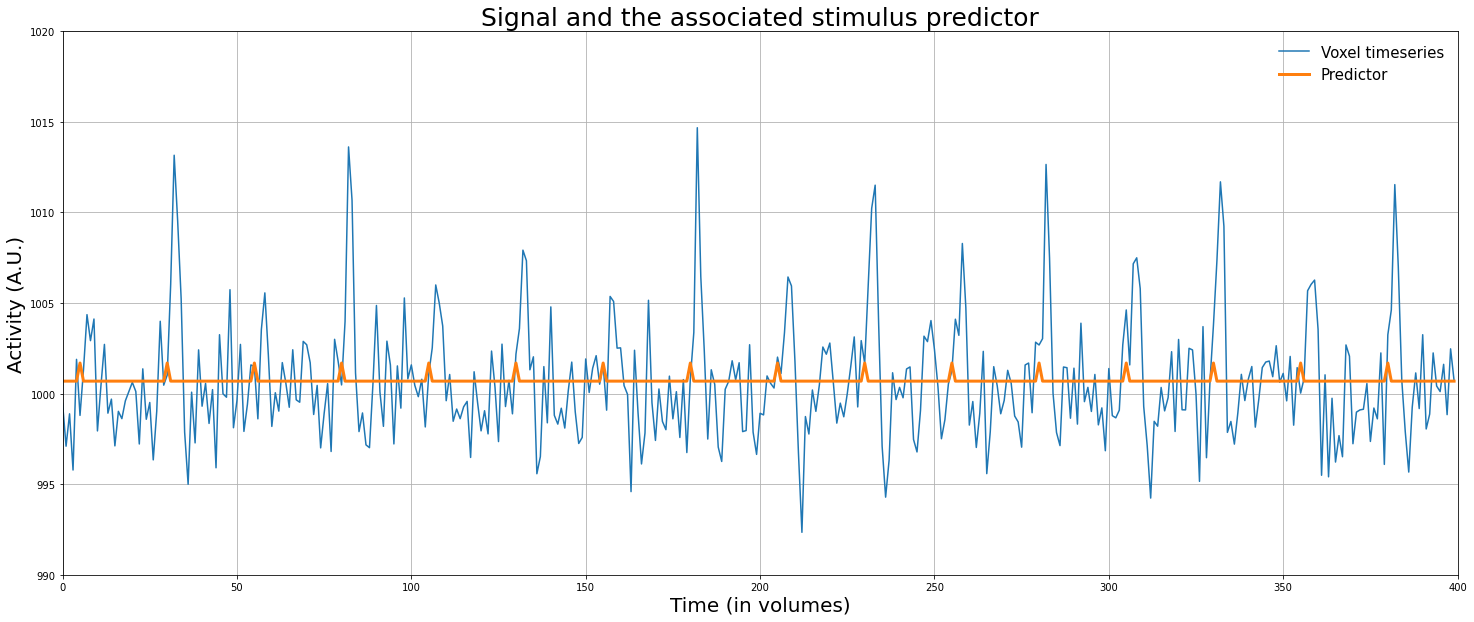

In [11]:
plt.figure(figsize=(25, 10))
plt.plot(voxel_signal)
plt.plot(predictor_all_ds + voxel_signal.mean(), lw=3)
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.xlabel('Time (in volumes)', fontsize=20)
plt.ylabel('Activity (A.U.)', fontsize=20)
plt.legend(['Voxel timeseries', 'Predictor'], fontsize=15, loc='upper right', frameon=False)
plt.title("Signal and the associated stimulus predictor", fontsize=25)
plt.grid()
plt.show()

Often, the design matrix is actually specified with higher precision (e.g., on the scale of milliseconds) than we did in the previous example (i.e., seconds) to accomodate onsets that are not "locked" to full seconds (e.g., $t=10$, $t=60$, but never $t=10.296$). We'll come back to this issue later in the tutorial.

But first, let's practice!

<div class='alert alert-warning'><b>ToDo1</b>: Below, we've defined an array of onsets (<tt>onsets2</tt>) belonging to a hypothetical experiment with a duration of 60 seconds and a TR of 3. Create a predictor at the timescale of seconds (should have a length of 60) and name this <tt>pred2</tt>. Then, downsample the predictor to the scale of the experiment (i.e., resample the predictor to the timepoints $t=0, t=3, t=6, t=9, ... , t=57$). Store this downsampled predictor in a variable named <tt>pred2_ds</tt>.
</div>

In [24]:
# Implement your ToDo Here
onsets2 = np.array([12, 24, 33, 42], dtype=int)

# First create pred2
pred2 = np.zeros(60)
pred2[onsets2] = 1
original_scale = np.arange(0, 60, 1)  # from 0 to 60 seconds
print("Original scale has %i datapoints (0,1,2, ... 60, in volumes" % original_scale.size)

# Then downsample it to create pred2_ds
resampler = interp1d(original_scale, pred2)
desired_scale = np.arange(0, 60, 3)
print("Desired scale has %i datapoints (0, 3, 6, ... 60, in volumes)" % desired_scale.size)
pred2_ds = resampler(desired_scale)

print("Downsampled predictor has %i datapoints (in volumes)" % pred2_ds.size)

Original scale has 60 datapoints (0,1,2, ... 60, in volumes
Desired scale has 20 datapoints (0, 3, 6, ... 60, in volumes)
Downsampled predictor has 20 datapoints (in volumes)


At this moment, we have everything that we need to run linear regression: a predictor (independent variable) and a signal (target/dependent variable) at the same scale and the same number of data points! This regression analysis allows us to answer the question whether the activity of the signal is significantly different when a stimulus is presented (i.e., at times when the predictor contains ones) than when no stimulus is presented (i.e., at times when the predictor contains zeros). 

Or, phrased differently (but mathematically equivalent): what is the effect of a unit increase in the predictor ($X = 0 = \mathrm{no\ stimulus} \rightarrow X = 1 = \mathrm{stimulus}$) on the target (the signal)? We will answer this question in the next section!

### Regression on fMRI data & interpretation parameters
As said before, applying regression analysis on fMRI data is done largely the same as on regular non-timeseries data. In the next, we're going to do exactly that.

We'll start by adding an intercept to <tt>predictor_all_ds</tt>, creating a new variable called <tt>X_simple</tt>. Then, we will run linear regression on the <tt>voxel_signal</tt> data and save the beta-parameters in a new variable named <tt>betas_simple</tt>. Finally, we will calculate MSE and $R^ 2$ for this model and store these values in new variables named <tt>mse_simple</tt> and <tt>r2_simple</tt>.

In [25]:
if predictor_all_ds.ndim == 1:  # do not remove this! This adds a singleton dimension, such that you can call np.hstack on it
    predictor_all_ds = predictor_all_ds[:, np.newaxis]

#Make an intercept vector
icept = np.ones((predictor_all_ds.size, 1))
#Add the intercept to the design matrix
X_simple = np.hstack((icept, predictor_all_ds))

# Solve the model
betas_simple = inv(X_simple.T @ X_simple) @ X_simple.T @ voxel_signal
#Make predicted values
y_hat_simple = X_simple.dot(betas_simple)
#Calculate mean squared error
mse_simple = np.mean((voxel_signal - y_hat_simple) ** 2)
#Calculate R-squared
r2_simple = 1 - (np.sum((y_hat_simple - voxel_signal) ** 2) / np.sum((voxel_signal.mean() - voxel_signal) ** 2))

print('Betas:',betas_simple)
print("MSE:",mse_simple)
print("R-squared:",r2_simple)

Betas: [1000.64701684    1.02307437]
MSE: 10.327387296195898
R-squared: 0.0038767539784904104


This gives us the following beta-parameters: 1000.657 for the intercept and 1.023 for our stimulus-predictor. This means that our linear regression model for that voxel is as follows:

\begin{align}
y_{voxel} = \beta_{intercept} + X_{stim}\beta_{stim} + \epsilon = 1000.647 + X_{stim}1.023 + \epsilon
\end{align}

This simply means that for a unit increase in $X$ (i.e., $X = 0 \rightarrow X = 1$), $y$ increases with 1.023. In other words, on average the signal is 1.023 higher when a stimulus is present compared to when a stimulus is absent!

To aid interpretation, let's plot the signal ($y$) and the predicted signal ($\hat{y} = \beta X$) in the same plot.

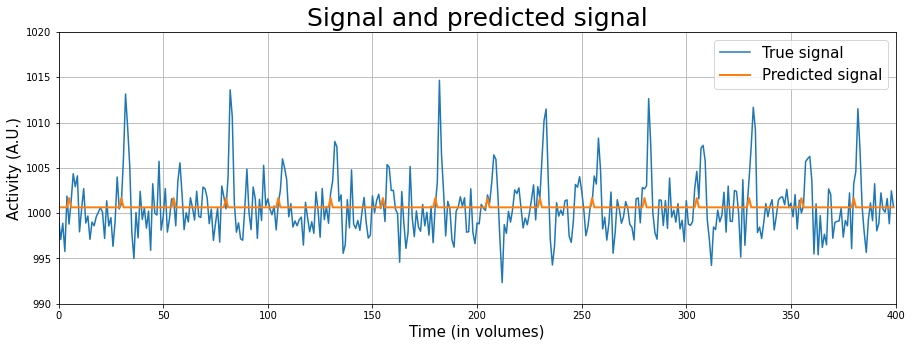

In [26]:
def plot_signal_and_predicted_signal(y, X, x_lim=None, y_lim=None):
    """ Plots a signal and its GLM prediction. """
    des = np.hstack((np.ones((y.size, 1)), X))
    # Use numpy to solve linear model
    betas_simple = np.linalg.lstsq(des, y, rcond=None)[0]
    plt.figure(figsize=(15, 5))
    plt.plot(y)
    plt.plot(des @ betas_simple, lw=2)
    plt.xlabel('Time (in volumes)', fontsize=15)
    plt.ylabel('Activity (A.U.)', fontsize=15)
    
    if x_lim is not None:
        plt.xlim(x_lim)
    
    if y_lim is not None:
        plt.ylim(y_lim)
    
    plt.legend(['True signal', 'Predicted signal'], loc='upper right', fontsize=15)
    plt.title("Signal and predicted signal", fontsize=25)
    plt.grid()
    plt.show()

    
plot_signal_and_predicted_signal(voxel_signal, predictor_all_ds, x_lim, y_lim)

The orange line represents the predicted signal, which is based on the original predictor ($X$) multiplied (or "scaled") by the associated beta-parameters ($\beta$). Graphically, you can interpret the beta-parameter of the stimulus-predictor ($\beta_{stim}$) as the maximum height of the peaks in the orange line\* and the beta-parameter of the intercept ($\beta_{intercept}$) as the difference from the flat portion of the orange line and 0 (i.e. the "offset" of the signal).

---
\* This holds true only when the maximum value of the original predictor is 1 (which is true in our case)

Let's zoom in on a portion of the data to show this:

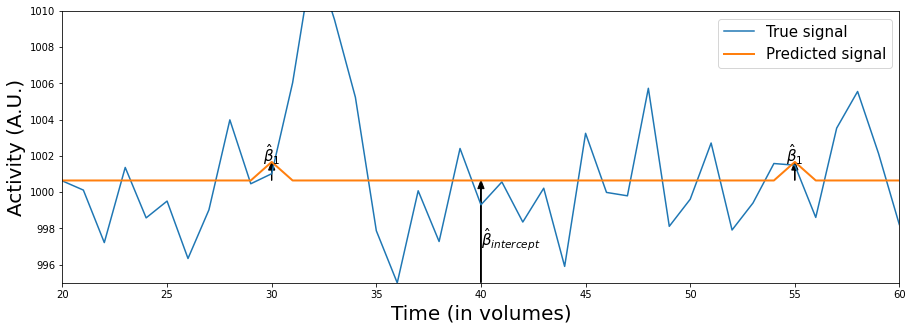

In [27]:
def plot_signal_and_predicted_signal_zoom(y, X, x_lim, y_lim, plot_params=True):
    """ Same as previous function, but zoomed in. """
    des = np.hstack((np.ones((y.size, 1)), X))
    betas_simple = np.linalg.lstsq(des, y, rcond=None)[0]
    yhat = des @ betas_simple
    plt.figure(figsize=(15, 5))
    plt.plot(y)
    plt.plot(yhat, lw=2)
    plt.xlim(x_lim)
    plt.ylim(y_lim)
    plt.xlabel('Time (in volumes)', fontsize=20)
    plt.ylabel('Activity (A.U.)', fontsize=20)
    
    if plot_params:
        xmid = (x_lim[1] + x_lim[0]) // 2
        plt.text(xmid, y_lim[0] + (betas_simple[0] - y_lim[0]) // 2, r"$\hat{\beta}_{intercept}$", fontsize=15)
        plt.arrow(xmid, y_lim[0], 0, betas_simple[0] - y_lim[0], head_width=0.3,
                  length_includes_head=True, color='k')

        for t in np.where(yhat[x_lim[0]:x_lim[1]] == yhat.max())[0]:
            t += x_lim[0]
            plt.arrow(t, betas_simple[0], 0, betas_simple[1], head_width=0.3,
                      length_includes_head=True, color='k')
            plt.text(t, betas_simple[0] + betas_simple[1], r"$\hat{\beta}_{1}$", fontsize=15, ha='center')
        
    plt.legend(['True signal', 'Predicted signal'], fontsize=15, loc='upper right')
    plt.show()
    
plot_signal_and_predicted_signal_zoom(voxel_signal, predictor_all_ds, x_lim=(20, 60), y_lim=(995, 1010))

Anyway, there seems to be an effect on voxel activity when we show a stimulus &mdash; an increase of 1.023 in the signal on average (about 0.1% percent signal change) &mdash; but you've also seen that the model fit is quite bad ($R^2 = 0.004$, about 0.4% explained variance) ...

What is happening here? Is our voxel just super noisy? Or is something wrong with our model? We'll talk about this in the next section!

### Using the BOLD response in GLM models
Let's go back to our original idea behind the predictor we created. We assumed that in order to model activity in response to our stimuli, our predictor should capture an increase/decrease in activity *at the moment of stimulus onset*. But this is, given our knowledge of the BOLD-response, kind of unrealistic to assume: it is impossible to measure instantaneous changes in neural activity in response to stimuli or tasks with fMRI, *because the BOLD-response is quite slow and usually peaks around 5-7 seconds **after** the 'true' neuronal activity (i.e. at cellular level)*. 

In the above model, we have not incorporated either the lag (i.e. ~6 seconds) or the shape of the BOLD-response: we simply modelled activity as an instantaneous response to a stimulus event. 

You can imagine that if you incorporate this knowledge about the BOLD-response into our model, the fit will likely get better! In this section, we'll investigate different ways to incorporate knowledge of the BOLD-response in our predictors.

#### The canonical HRF
The easiest and most often-used approach to incorporating knowledge about the BOLD-response in univariate analyses of fMRI data is to assume that each voxel responds to a stimulus in a fixed way. In other words, that voxels always respond (activate/deactivate) to a stimulus in the same manner. This is known as using a "canonical haemodynamic response function (HRF)". Basically, an HRF is a formalization of how we think the a voxel is going to respond to a stimulus. A *canonical* HRF is the implementation of an HRF in which you use the same HRF for each voxel, participant, and condition. There are other implementations of HRFs (apart from the canonical), in which you can adjust the exact shape of the HRF based on the data you have; examples of these HRFs are *temporal basis sets* and *finite impulse reponse models* (FIR), which we'll discuss later.

There are different types of (canonical) HRFs; each models the assumed shape of the BOLD-response slightly differently. For this course, we'll use the most often used canonical HRF: the double-gamma HRF, which is a combination of two different gamma functions (one modelling the overshoot and one modelling the post-stimulus undershoot).

We'll use the "double gamma" HRF implementation of the [nilearn](https://nilearn.github.io) Python package. They provide different "versions" of the HRF (which differ slightly in their shape); we'll use the "Glover" version, which is based on a double-[gamma function](https://en.wikipedia.org/wiki/Gamma_function): `glover_hrf`.

In [28]:
from nilearn.glm.first_level.hemodynamic_models import glover_hrf

/home/coder/.local/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


This function takes a couple of arguments (the most important being: TR, oversampling factor, and length of the HRF in seconds), and returns a double gamma HRF. It is important to make sure that your HRF is on the same timescale as our design (predictors). In the previous section, we made sure we defined our predict at the time scale of seconds first before downsampling it to a time resolution of 2 seconds (i.e., the TR). 

Thus, given a TR of 2, we can use a "oversampling factor" of 2 to get the HRF on the timescale of seconds:

In [29]:
TR = 2
osf = 2
length_hrf = 32  # sec

canonical_hrf = glover_hrf(tr=TR, oversampling=osf, time_length=length_hrf, onset=0)
canonical_hrf /= canonical_hrf.max()
print("Size of canonical hrf variable: %i" % canonical_hrf.size)

Size of canonical hrf variable: 32


As you can see, the length of the `canonical_hrf` variable is 32 (seconds). Now, let's plot it:

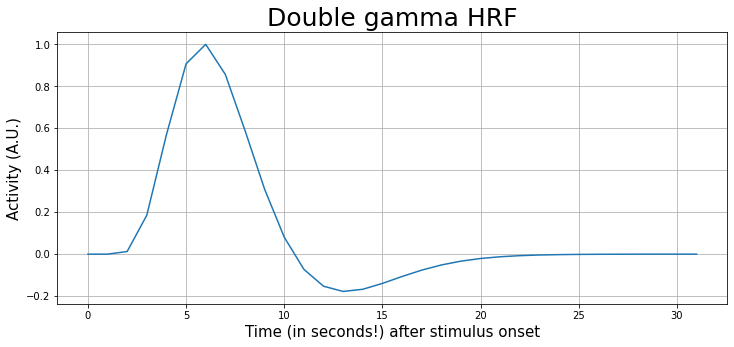

In [30]:
t = np.arange(0, canonical_hrf.size)

plt.figure(figsize=(12, 5))
plt.plot(t, canonical_hrf)
plt.xlabel('Time (in seconds!) after stimulus onset', fontsize=15)
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.title('Double gamma HRF', fontsize=25)
plt.grid()
plt.show()

#### Convolution
The figure of the HRF shows how we'd expect that an idealized (noiseless) response to a single event would look like. But how should we incorporate this HRF into our model? Traditionally, this is done using a mathematical operation called **convolution**. Basically, it "slides" the HRF across our 0-1 coded stimulus-vector from left to right and elementwise multiplies the HRF with the stimulus-vector. This is often denoted as:

\begin{align}
X_{\mathrm{conv}} = \mathrm{HRF} * X_{\mathrm{original}}
\end{align}

in which $*$ is the symbol for convolution, $X_{\mathrm{original}}$ is the original stimulus-vector, and $X_{\mathrm{conv}}$ the result of the convolution.

Let's plot an example to make it clearer. Suppose we have an onset-vector of length 100 (i.e., the experiment was 100 seconds long) with three stimulus presentations: at $t = 10$, $t = 40$, and $t = 70$. The stimulus-vector (upper plot), double-gamma HRF (right plot), and the result of the convolution of the stimulus-vector and the HRF (lower plot) looks as follows:

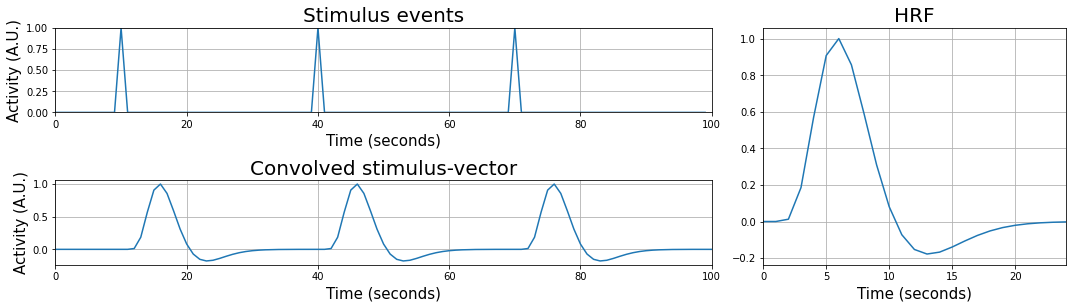

In [31]:
random_stimulus_onsets = [10, 40, 70]
random_stim_vector = np.zeros(100)
random_stim_vector[random_stimulus_onsets] = 1

#We will use the numpy function np.convolve() to convolve the stim vector with the HRF
convolved_stim_vector = np.convolve(random_stim_vector, canonical_hrf, 'full')

#We will plot all three variables in a grid.

#First, the stimulus vector
plt.figure(figsize=(15, 6))
plt.subplot2grid((3, 3), (0, 0), colspan=2)
plt.plot(random_stim_vector)
plt.xlim((0, 100))
plt.ylim((0, 1))
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.xlabel('Time (seconds)', fontsize=15)
plt.title('Stimulus events', fontsize=20)
plt.grid()

#Second, the hemodynamic response function
plt.subplot2grid((3, 3), (0, 2), rowspan=2)
plt.plot(canonical_hrf)
plt.title('HRF', fontsize=20)
plt.xlim(0, 24)
plt.xlabel("Time (seconds)", fontsize=15)
plt.grid()

#Lastly, the combination
plt.subplot2grid((3, 3), (1, 0), colspan=2)
plt.plot(convolved_stim_vector)
plt.title('Convolved stimulus-vector', fontsize=20)
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.xlabel('Time (seconds)', fontsize=15)
plt.xlim(0, 100)
plt.tight_layout()
plt.grid()
plt.show()

The result &mdash; the convolved stimulus-vector &mdash; is basically the output of a the multiplication of the HRF and the stimulus-events when you would "slide" the HRF across the stimulus vector. As you can see, the convolved stimulus-vector correctly shows the to-be-expected lag and shape of the BOLD-response! Given that this new predictor incorporates this knowledge of the to-be expected response, it will probably model the activity of our voxel way better. Note that the temporal resolution of your convolved regressor is necessary limited by the resolution of your data (i.e. the TR of your fMRI acquisition). That's why the convolved regressor doesn't look as "smooth" as the HRF. 

As you can see in the code for the plot above, numpy provides us with a function to convolve two arrays:

```python
np.convolve(array_1, array_2)
```

Now, we can convolve the HRF with out stimulus-predictor. Importantly, we want to do this convolution operation in the resolution of our onsets (here: seconds), not in the resolution of our signal (TR) (the reason for this is explained clearly in Jeanette Mumford's [video on the HRF](https://www.youtube.com/watch?v=5JNX34gYG7Q).)
Therefore, we need to perform the convolution on the variable `predictor_all` (*not* the downsampled variable: `predictor_all_ds`)!

We'll do this below (we'll reuse the `canonical_hrf` variable defined earlier):

In [32]:
'''We need to "squeeze" out the extra singleton axis, because that's
what the np.convolve function expects, i.e., arrays of shape (N,) and NOT (N, 1)
To go from (N, 1) --> (N,) we'll use the squeeze() method'''
predictor_conv = np.convolve(predictor_all.squeeze(), canonical_hrf)

print("The shape of the convolved predictor after convolution: %s" % (predictor_conv.shape,))

# After convolution, we also neem to "trim" off some excess values from
# the convolved signal (the reason for this is not important to understand)
predictor_conv = predictor_conv[:predictor_all.size]

print("After trimming, the shape is: %s" % (predictor_conv.shape,))

# And we have to add a new axis again to go from shape (N,) to (N, 1),
# which is important for stacking the intercept, later
predictor_conv = predictor_conv[:, np.newaxis]

print("Shape after adding the new axis: %s" % (predictor_conv.shape,))

The shape of the convolved predictor after convolution: (831,)
After trimming, the shape is: (800,)
Shape after adding the new axis: (800, 1)


It's a bit of a hassle (squeezing out the singleton axis, trimming, adding the axis back ...), but now we have a predictor which includes information about the expected HRF!

Let's look at the predictor before and after convolution in the same plot:

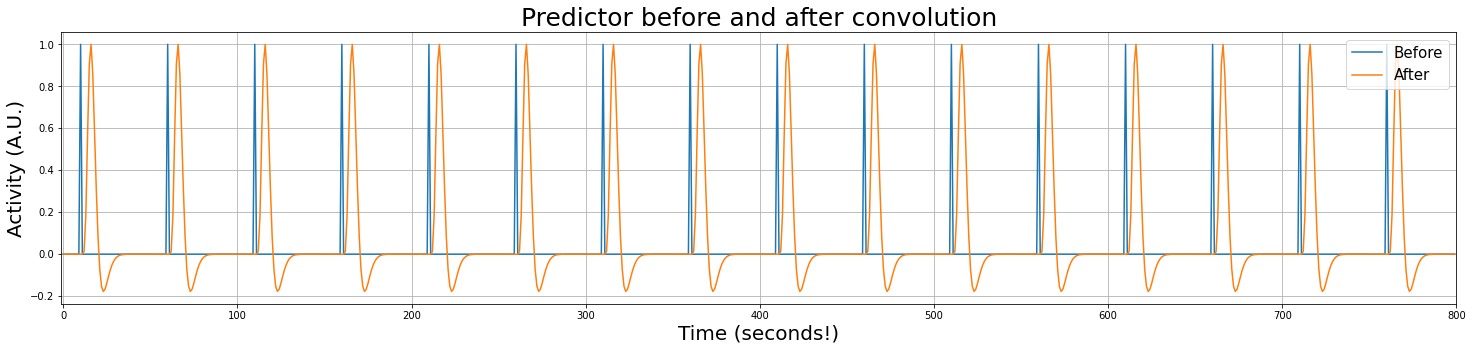

In [33]:
plt.figure(figsize=(25, 5))
plt.plot(predictor_all)
plt.plot(predictor_conv)
plt.xlim(-1, 800)
plt.title("Predictor before and after convolution", fontsize=25)
plt.xlabel("Time (seconds!)", fontsize=20)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.legend(['Before', 'After'], loc='upper right', fontsize=15)
plt.grid()
plt.show()

#### Linear scaling
Great! Our predictor now includes the expected 'lag' and shape of the HRF, and we can start analyzing our signal with our new convolved predictor! But before we'll do this, there is one more concept that we'll demonstrate. This is the concept of **linear scaling** of the BOLD-response. This assumes that the BOLD-response will linearly scale with the input it is given.

Let's see how that works:

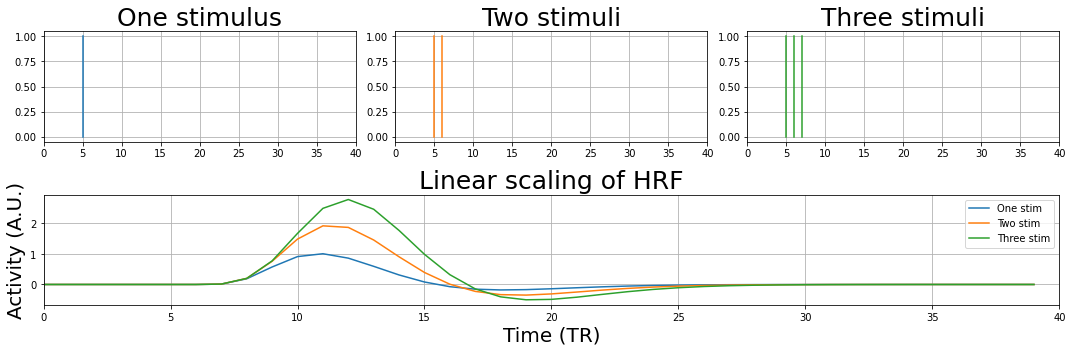

In [34]:
plt.figure(figsize=(15, 5))

N = 40
one_stim = np.zeros(N)
one_stim[5] = 1
one_stim_conv = np.convolve(one_stim, canonical_hrf)[:N]
two_stim = np.zeros(N)
two_stim[[5, 6]] = 1
two_stim_conv = np.convolve(two_stim, canonical_hrf)[:N]
three_stim = np.zeros(N)
three_stim[[5, 6, 7]] = 1
three_stim_conv = np.convolve(three_stim, canonical_hrf)[:N]

plt.subplot2grid((2, 3), (0, 0))
for ons in np.where(one_stim)[0]:
    plt.plot([ons, ons], [0, 1])

plt.xlim(0, N)
plt.title("One stimulus", fontsize=25)
plt.grid()

plt.subplot2grid((2, 3), (0, 1))
for ons in np.where(two_stim)[0]:
    plt.plot([ons, ons], [0, 1], c='tab:orange')

plt.xlim(0, N)
plt.title("Two stimuli", fontsize=25)
plt.grid()

plt.subplot2grid((2, 3), (0, 2))
for ons in np.where(three_stim)[0]:
    plt.plot([ons, ons], [0, 1], c='tab:green')

plt.xlim(0, N)    
plt.title("Three stimuli", fontsize=25)
plt.grid()

plt.subplot2grid((2, 3), (1, 0), colspan=3)
plt.plot(one_stim_conv)
plt.plot(two_stim_conv)
plt.plot(three_stim_conv)
plt.legend(['One stim', 'Two stim', 'Three stim'])
plt.title('Linear scaling of HRF', fontsize=25)
plt.ylabel('Activity (A.U.)', fontsize=20)
plt.xlabel('Time (TR)', fontsize=20)
plt.xlim(0, N)
plt.grid()
plt.tight_layout()
plt.show()

Also, in our random stimulus-vector above (and also in the example we showed earlier) we assumed that each image was only showed briefly (i.e. we only modelled the onset) - but what if a stimulus (or task) may take longer, say, 15 seconds? Let's see what happens.

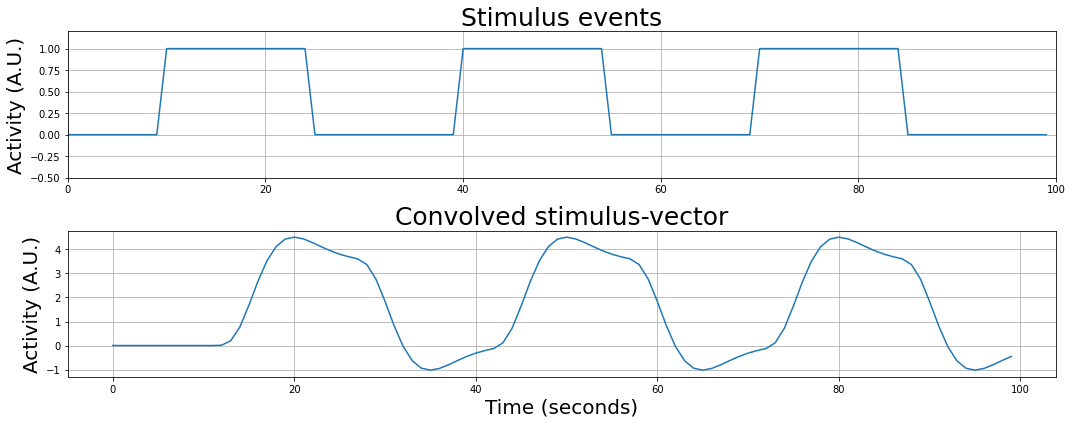

In [35]:
random_stimulus_onsets2 = list(range(10, 25)) + list(range(40, 55)) + list(range(70, 85))
random_stim_vector2 = np.zeros(100)

random_stim_vector2[random_stimulus_onsets2] = 1

plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.grid()
plt.plot(random_stim_vector2, c='tab:blue')

plt.xlim((0, 100))
plt.ylim((-.5, 1.2))
plt.ylabel('Activity (A.U.)', fontsize=20)

plt.title('Stimulus events', fontsize=25)

convolved_stim_vector2 = np.convolve(random_stim_vector2, canonical_hrf)[:random_stim_vector2.size]
plt.subplot(2, 1, 2)
plt.plot(convolved_stim_vector2)
plt.title('Convolved stimulus-vector', fontsize=25)
plt.ylabel('Activity (A.U.)', fontsize=20)
plt.xlabel('Time (seconds)', fontsize=20)
plt.grid()
plt.tight_layout()
plt.show()

As you can see, convolution takes care to model the shape of the BOLD-response according to how long you specify the stimulus to take! 

<div class='alert alert-info'>
<b>ToThink2</b>: Given the properties of the BOLD-response (and assuming linear-time invariance is not violated), would you expect the same or a different BOLD-response in response to 3 consecutive stimuli (of the same condition) of half a second second each (which follow each other immediately, i.e. without interstimulus interval) versus 1 stimulus of 1.5 seconds? Why? (Write your answer in the text-cell below.)
</div>

Write you solution to <b>ToThink2</b> here (solutions at the end of the notebook):

#### Convolutions galore

Actually, convolution can model *any* sequence of stimulus events, even stimuli with random onsets - just look at the plot below!

(you can execute this cell below multiple times to see different random regressor shapes!)

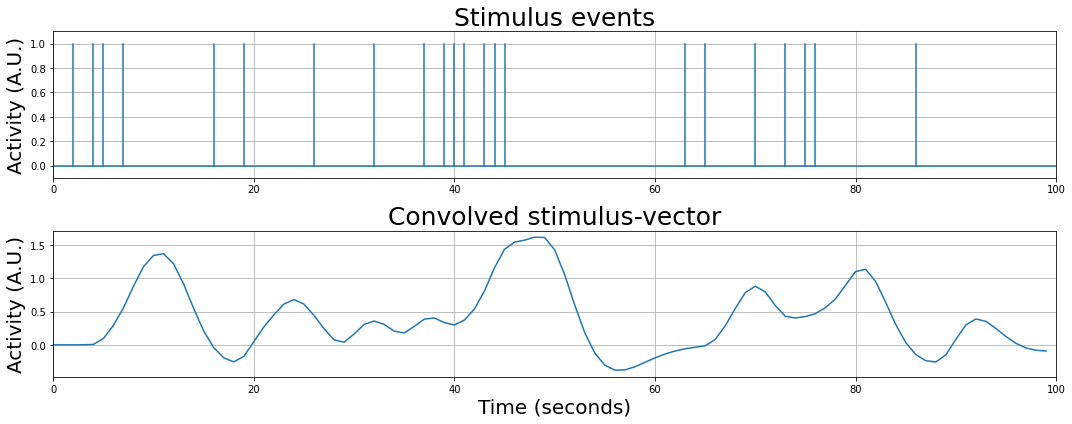

In [36]:
random_stimulus_onsets3 = np.random.randint(0, 100, 25)
random_stim_vector3 = np.zeros(100)
random_stim_vector3[random_stimulus_onsets3] = 1

plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)

plt.axhline(0)
for i, event in enumerate(random_stim_vector3):
    if event != 0.0:
        plt.plot((i, i), (0, 1), '-', c='tab:blue')

plt.xlim((0, 100))
plt.ylim((-0.1, 1.1))
plt.ylabel('Activity (A.U.)', fontsize=20)
plt.title('Stimulus events', fontsize=25)
plt.grid()

convolved_stim_vector3 = np.convolve(random_stim_vector3 * .5, canonical_hrf, 'full')[:random_stim_vector3.size]
plt.subplot(2, 1, 2)
plt.plot(convolved_stim_vector3)
plt.xlim(0, 100)
plt.title('Convolved stimulus-vector', fontsize=25)
plt.ylabel('Activity (A.U.)', fontsize=20)
plt.xlabel('Time (seconds)', fontsize=20)
plt.grid()

plt.tight_layout()
plt.show()

<div class='alert alert-warning'>
    <b>ToDo2</b>: Let's assume that we did an experiment in which participants were presented with a visual stimulus lasting 20 seconds six times over the course of an experiment of 3 minutes (starting at $t=0$, $t=30$, ... , $t=150$ sec). Create a stimulus predictor (on the timescale of seconds), store this in a variable named <tt>todo_pred</tt>, and then convolve this predictor with the <tt>canonical_hrf</tt> variable. Make sure to trim the convolved predictor, and store the result in a variable named <tt>todo_pred_conv</tt>.
</div>

In [40]:
# Implement your ToDo2 solution here:

# create predictor
todo_pred = np.zeros(180)
time_stamps = [0, 30, 60, 90, 120, 150]
todo_pred[time_stamps] = 1

# convolve predictor
todo_pred_conv = np.convolve(todo_pred, canonical_hrf)
print("The shape of the convolved predictor after convolution: %s" % (todo_pred_conv.shape,))

# trim 
todo_pred_conv_trim = todo_pred_conv[:todo_pred.size]
print("After trimming, the shape is: %s" % (todo_pred_conv_trim.shape,))

The shape of the convolved predictor after convolution: (211,)
After trimming, the shape is: (180,)


<b>So, in summary</b>, convolving the stimulus-onsets (and their duration) with the HRF gives us (probably) a better predictor of the voxel signal than just the stimulus-onset, because (1) it models the lag of the BOLD-response and (2) models the shape of the BOLD-response (accounting for the linear scaling principle). 

#### Resampling revisited
Now, we're *almost* ready to start analyzing our signal with the convolved predictor! The problem, at this moment, however is that the convolved predictor and the signal are on different scales!

In [41]:
print("Size convolved predictor: %i" % predictor_conv.size)
print("Size voxel signal: %i" % voxel_signal.size)

Size convolved predictor: 800
Size voxel signal: 400


We can use resampling to find the data points of the convolved HRF predictor that correspond to the onset of the volumes of our voxel signal. Importantly, we have to "squeeze out" the singleton dimension before downsampling the predictor (otherwise it'll give an error). Then, we can plot the convolved predictor and the signal in the same figure (because now they are defined on the same timescale!):

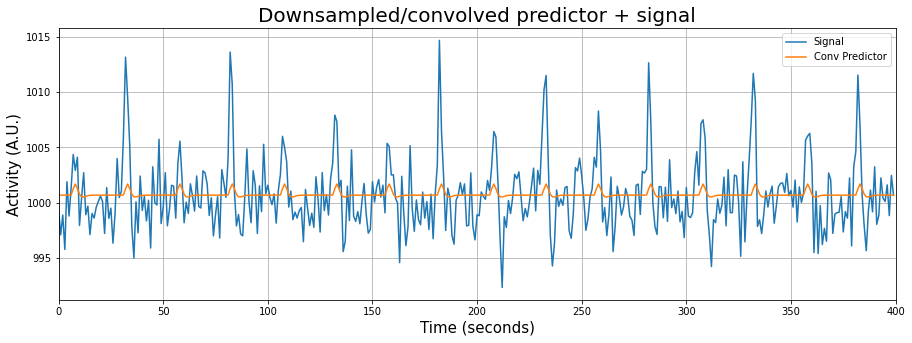

In [42]:
original_scale = np.arange(0, 800)
resampler = interp1d(original_scale, np.squeeze(predictor_conv))

desired_scale = np.arange(0, 800, 2)
predictor_conv_ds = resampler(desired_scale)

plt.figure(figsize=(15, 5))
plt.plot(voxel_signal)
plt.plot(predictor_conv_ds + voxel_signal.mean())
plt.grid()
plt.title('Downsampled/convolved predictor + signal', fontsize=20)
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.xlabel('Time (seconds)', fontsize=15)
plt.legend([ 'Signal','Conv Predictor'])
plt.xlim(x_lim)
plt.show()

#### Initial upsampling of predictors
In the previous examples, the resampling process came down to selecting every other datapoint (at $t=0$, $t=2$, $t=4$, ..., $t=798$), because our onsets were all "locked" to "round" seconds (e.g., $t=10$, $t=60$, but never $t=10.29$ or something). Very often, however, stimuli (or whatever you're using to construct your predictors) are not locked to "round" seconds. How would you then initially create a predictor? One way is to do so is to create your stimulus predictor on a more precise timescale, such as on hundredths of seconds (i.e., with a precision of 0.01 seconds). In other words, we oversample the predictor with a factor 100. Then, we can set the indices in this oversampled predictor to our onsets with a higher precision (e.g., for a particular onset at 5.12 seconds, we can set the predictor at index 512 to 1).

Let's do this below for some hypothetical onsets logged with millisecond precision for an experiment lasting 50 seconds:

In [43]:
onsets2 = np.array([3.62, 16.26, 34.12, 42.98])  # in seconds
duration = 50  # duration experiment in seconds
osf = 100  # osf = OverSampling Factor

pred2 = np.zeros(duration * osf)
print("Size of oversampled (factor: 1000) predictor: %i" % pred2.size)

onsets2_in_msec = (onsets2 * osf).astype(int)  # we convert it to int, because floats (even when it's 5.0) cannot be used as indices
pred2[onsets2_in_msec] = 1

Size of oversampled (factor: 1000) predictor: 5000


Now, to convolve this signal, we should also define our HRF with a higher temporal precision (i.e., hundredths of seconds). Notice that the HRF is also a lot smoother when defined it on a timescale of seconds.

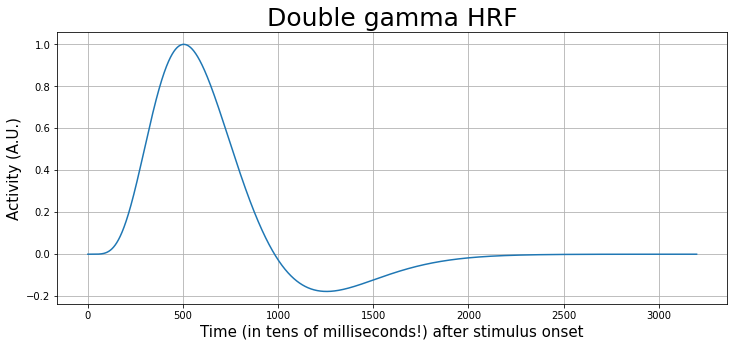

In [44]:
osf = 100 * TR
hrf_ms = glover_hrf(tr=TR, oversampling=osf, time_length=32)
hrf_ms /= hrf_ms.max()  # scale such that max = 1

t = np.arange(0, hrf_ms.size)

plt.figure(figsize=(12, 5))
plt.plot(t, hrf_ms)
plt.xlabel('Time (in tens of milliseconds!) after stimulus onset', fontsize=15)
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.title('Double gamma HRF', fontsize=25)
plt.grid()
plt.show()

Now, let's convolve our predictor with the HRF again:

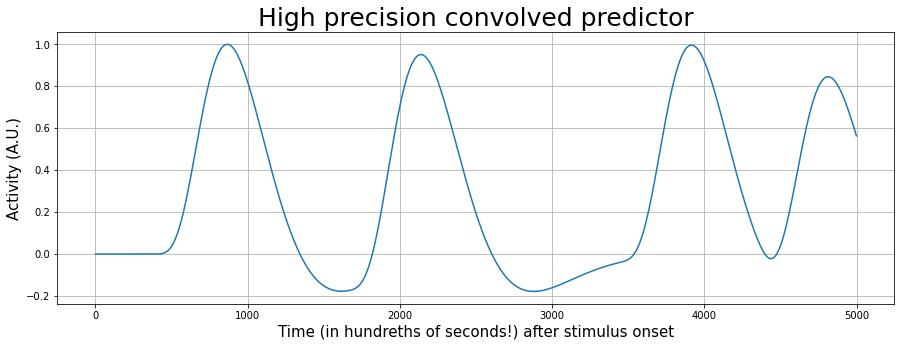

In [45]:
pred2_conv = np.convolve(pred2, hrf_ms)[:pred2.size]

plt.figure(figsize=(15, 5))
plt.plot(pred2_conv)
plt.xlabel('Time (in hundreths of seconds!) after stimulus onset', fontsize=15)
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.title('High precision convolved predictor', fontsize=25)
plt.grid()
plt.show()

Now the only thing that we have to do is to downsample the convolved predictor!

<div class='alert alert-warning'>
    <b>ToDo3</b>: Assuming that the described experiment had a TR of 1.25 seconds and 40 volumes, downsample the convolved predictor (<tt>pred2_conv</tt>) to the timescale of the hypothetical signal (i.e., resample the predictor to the timepoints $t=0, t=1.25, t=2.5, ... , t=48.75$). Call this downsampled predictor <tt>pred2_conv_ds</tt>.

Tip: think about the original scale (msec) and the desired scale (steps of 1.25 sec) of your predictor.
</div>

In [48]:
# Implement your ToDo3 here
original_scale = np.arange(0, duration, 0.01)  # in steps of 0.01 seconds, i.e., hundredths of seconds

TR = 1.25
resampler = interp1d(original_scale, pred2_conv)
desired_scale = np.arange(0, 50, TR)
pred2_conv_ds = resampler(desired_scale)
### END SOLUTION
# tyvstjålet fra solutions
print(pred2_conv_ds.shape)

(40,)


#### Fitting an HRF-informed model
Finally ... we're ready to see whether the HRF-based predictor *actually* models our original voxel signal (`voxel_signal`, from earlier in the tutorial) more accurately! Let's create a proper design-matrix ($X$) by stacking an intercept with the stimulus-regressor, perform the regression analysis, and check out the results (by plotting the predicted signal against the true signal). For comparison, we'll also plot the original (unconvolved) model as well!

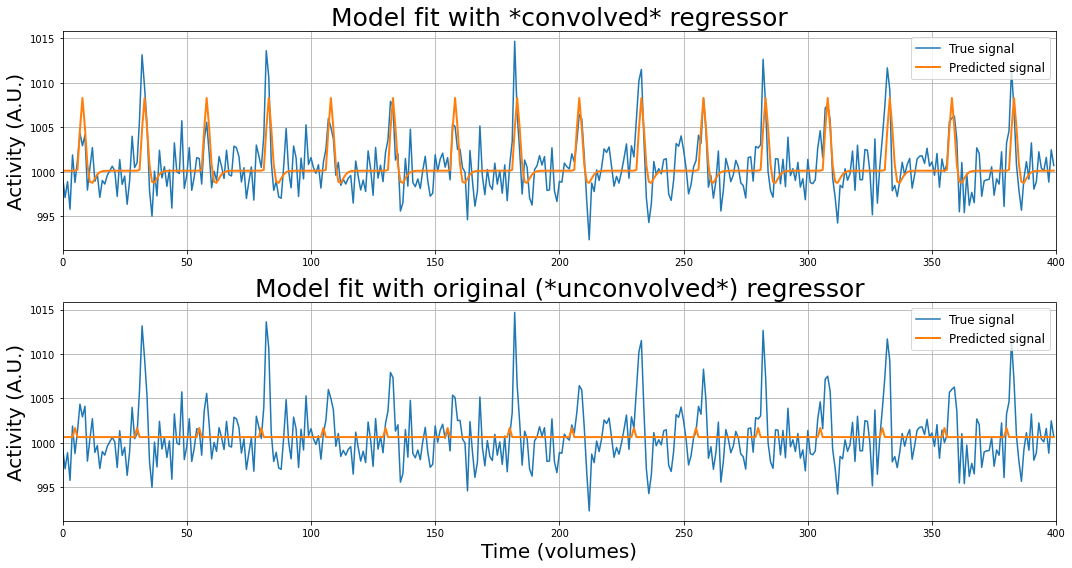

In [49]:
if predictor_conv_ds.ndim == 1:
    # Add back a singleton axis (which was removed before downsampling)
    # otherwise stacking will give an error
    predictor_conv_ds = predictor_conv_ds[:, np.newaxis]

#Making an intercept regressor
intercept = np.ones((predictor_conv_ds.size, 1))

# Combine predictor and intercept
X_conv = np.hstack((intercept, predictor_conv_ds))

#Solving the regrsssion
betas_conv = inv(X_conv.T @ X_conv) @ X_conv.T @ voxel_signal

#Calculate predicted signal from model with convolution
y_hat_conv = X_conv @ betas_conv

#Calculate predicted signal from the simple model (estimted above)
y_hat_simple = X_simple @ betas_simple


plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(voxel_signal)
plt.plot(y_hat_conv, lw=2)
plt.xlim(x_lim)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.title("Model fit with *convolved* regressor", fontsize=25)
plt.legend(['True signal', 'Predicted signal'], fontsize=12, loc='upper right')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(voxel_signal)
betas_simple = np.array([1000.64701684, 1.02307437])
plt.plot(y_hat_simple, lw=2)
plt.xlim(x_lim)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.title("Model fit with original (*unconvolved*) regressor", fontsize=25)
plt.legend(['True signal', 'Predicted signal'], fontsize=12, loc='upper right')
plt.xlabel("Time (volumes)", fontsize=20)
plt.grid()

plt.tight_layout()
plt.show()

Wow, that looks much better! First, let's inspect the beta-parameters:

In [50]:
print('The beta-parameter of our stimulus-predictor is now: %.3f' % betas_conv[1])
print('... which is %.3f times larger than the beta of our original '
      'beta (based on the unconvolved predictors)!' % (betas_conv[1] / betas_simple[1]))

The beta-parameter of our stimulus-predictor is now: 8.181
... which is 7.997 times larger than the beta of our original beta (based on the unconvolved predictors)!


Like we did before, we'll zoom in and show you how the estimated beta-parameters relate tho the data:

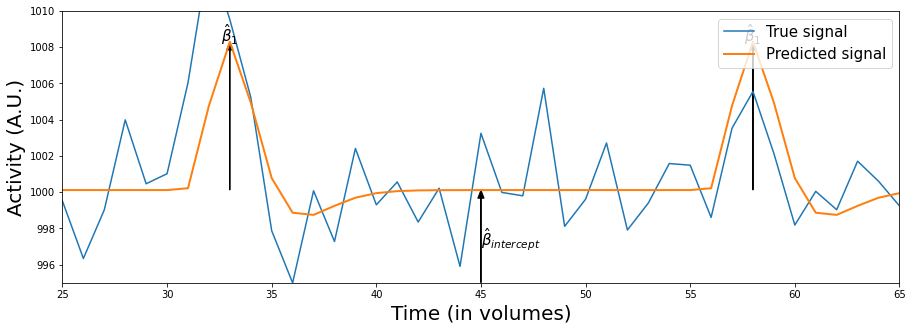

In [51]:
#This cell requires that you have run the cell above defining the function
plot_signal_and_predicted_signal_zoom(voxel_signal, predictor_conv_ds, x_lim=(25, 65), y_lim=(995, 1010))

Alright, so we seem to measure a way larger effect of our stimulus on the voxel activity, but is the model fit actually also better? Let's find out.

In [52]:

# Using the predicted values (y_hat...) that we calculated for the plots above
MSE_conv = ((y_hat_conv - voxel_signal) ** 2).mean()
MSE_simple = ((y_hat_simple - voxel_signal) ** 2).mean()

print("MSE of model with convolution is %.3f while the MSE of the model without convolution is %.3f." %
     (MSE_conv, MSE_simple))

#Calculating R-squared
R2_conv = 1 - (np.sum((voxel_signal - y_hat_conv) ** 2) / np.sum((voxel_signal - voxel_signal.mean()) ** 2))
R2_simple = 1 - (np.sum((voxel_signal - y_hat_simple) ** 2) / np.sum((voxel_signal - voxel_signal.mean()) ** 2))

print("R-squared of model with convolution is %.5f and without convolution it is %.5f." % 
     (R2_conv, R2_simple))

MSE of model with convolution is 6.022 while the MSE of the model without convolution is 10.327.
R-squared of model with convolution is 0.41919 and without convolution it is 0.00388.


From the model fit metrics above, we can safely conclude that (at least for this voxel), a design ($X$) in which we include information about the expected lag/shape of the HRF is *way* better than a 'HRF-naive' design (i.e. an unconvolved design). 

<div class='alert alert-warning'>
<b>ToDo4</b>:
    
So far, our examples were based on the stimulus-onsets of the two conditions (circles and squares) lumped together. This tested the hypothesis of our voxel responded to *any kind* of stimulus -- regardless of the condition (squares/circles) of the stimulus. Usually, however, you want to estimate the betas for each condition separately (i.e., how much each condition on average activates a voxel) and test the influence of each condition on the voxel separately (but estimated in the same model)! This is what you're going to do in this ToDo.

We provide you with the predictors for circles (<tt>predictor_circles</tt>) and for squares (<tt>predictor_squares</tt>) below. You have to do the following:

- convolve each predictor with the double-gamma HRF (use <tt>canonical_hrf</tt>) separately (don't forget to squeeze, trim, and add the axis back)
- downsample the convolved predictors
- stack an intercept and the two predictors **in a single design-matrix** ($X$) -- use <tt>np.hstack((intercept, pred1, pred2))</tt> for this
- calculate the beta-parameters (estimated in a single model!)
- calculate MSE (store this in the variable <tt>mse_new</tt>) and $R^2$ (store this in the variable <tt>r2_new</tt>)
</div>

In [76]:
# ToDo4
predictor_circles = np.zeros((800, 1))
predictor_circles[onsets_circles] = 1
print("The shape of the circle predictor before convolution: %s" % (predictor_circles.shape,))

predictor_squares = np.zeros((800, 1))
predictor_squares[onsets_squares] = 1
print("The shape of the square predictor before convolution: %s" % (predictor_squares.shape,))

# Implement your solution for ToDo4 below (find solution at the end of the notebook)
# convolve and squeeze
pred_cir_conv = np.convolve(predictor_circles.squeeze(), canonical_hrf)
print("The shape of the convolved circles predictor after convolution: %s" % (pred_cir_conv.shape,))

pred_squ_conv = np.convolve(predictor_squares.squeeze(), canonical_hrf)
print("The shape of the convolved squares predictor after convolution: %s" % (pred_squ_conv.shape,))

# trim
pred_cir_conv = pred_cir_conv[:predictor_circles.size]
print("After trimming, the shape is: %s" % (pred_cir_conv.shape,))

pred_squ_conv = pred_squ_conv[:predictor_squares.size]
print("After trimming, the shape is: %s" % (pred_squ_conv.shape,))

# downsampling
original_scale = np.arange(0,800,1)
desired_scale = np.arange(0,800,2)

resampler = interp1d(original_scale, pred_cir_conv)
pred_cir_conv = resampler(desired_scale)

resampler = interp1d(original_scale, pred_squ_conv)
pred_squ_conv = resampler(desired_scale)

# add axis back 
pred_cir_conv = pred_cir_conv[:, np.newaxis]
print("Shape after adding the new axis to the circles predictor and downsampling: %s" % (pred_cir_conv.shape,))

pred_squ_conv = pred_squ_conv[:, np.newaxis]
print("Shape after adding the new axis to the squares predictor and downsampling: %s" % (pred_squ_conv.shape,))

# stack intercept and predictors in a single design-matrix
intercept = np.ones((pred_cir_conv.size,1))

X_conv = np.hstack((intercept, pred_cir_conv, pred_squ_conv))
print(X_conv.shape) # it fits

# calculate the beta-parameters 
beta_est = inv(X_conv.T @ X_conv) @ X_conv.T @ voxel_signal

# calculate y_hat
y_hat = X_conv @ beta_est

# calculate MSE
mse_new = np.mean((voxel_signal - y_hat)**2)
print("MSE is %.2f" % mse_new)

# calculate R_squared
r2_new = 1 - (np.sum((y_hat - voxel_signal)**2) / np.sum((np.mean(voxel_signal)-voxel_signal)**2))
print("R-squared is %.4f" % r2_new)


The shape of the circle predictor before convolution: (800, 1)
The shape of the square predictor before convolution: (800, 1)
The shape of the convolved circles predictor after convolution: (831,)
The shape of the convolved squares predictor after convolution: (831,)
After trimming, the shape is: (800,)
After trimming, the shape is: (800,)
Shape after adding the new axis to the circles predictor and downsampling: (400, 1)
Shape after adding the new axis to the squares predictor and downsampling: (400, 1)
(400, 3)
MSE is 5.88
R-squared is 0.4333


<div class='alert alert-info'>
<b>ToThink3</b>: If you've done the above ToDo correctly, you should have found that the model fit of the design-matrix with the circles and squares predictors separately (as you did in the ToDo) leads to a (somewhat) better model fit (lower MSE/higher $R^2$) than the design-matrix with the conditions lumped together in a single predictor (as we did earlier).

Argue why you think this may be the case here.
</div>

Write your solution to ToThink2 here:

#### Temporal basis functions
Most studies use a canonical HRF to convolve with their predictors. However, remember that using a canonical HRF assumes that the particular shape of that HRF will be appropriate for each voxel, each condition, and each subject in your study. This is quite a strong assumption. In fact, studies have shown that the exact shape of the HRF often differs between voxels, conditions, and subjects (as is explained in detail by the [video on basis sets](https://www.youtube.com/watch?v=YfeMIcDWwko&index=21&list=PLcvMDPDk-dSmTBejANv7kY2mFo1ni_gkA) by Tor Wager).

In fact, this might also be the case in our data! If you've done the ToDo4 correctly, you might have seen that the predictions ($\hat{y}$) seem to "peak" too late for the circle-stimuli ... In fact, let's plot the data ($y$) and the prediction (based on the previously defined stimulus predictor, i.e., the circles and squares in a single predictor):

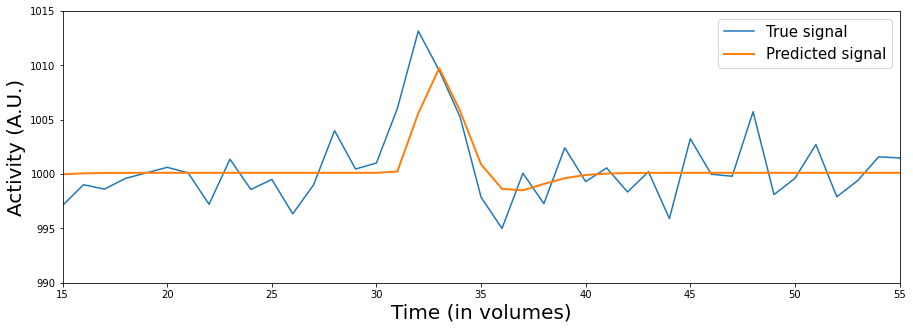

In [77]:
plot_signal_and_predicted_signal_zoom(voxel_signal, X_conv, x_lim=(15, 55), y_lim=(990, 1015), plot_params=False)

So, what should be do about this? Well, one solution is to use *temporal basis functions* (also called *temporal basis sets*). Temporal basis functions model the HRF as *a combination of (hemodynamic response) functions*. 

In practice, this amounts to convolving your predictor with not one, but multiple HRFs. This results in multiple predictors per stimulus-condition! Each HRF measures a "part" (or property) of the total HRF. Together, these predictors aim to estimate the complete HRF for a given stimulus-vector (condition). 

We're going to use *double-gamma basis functions* as an example of a temporal basis set (but there are other sets, like the (*single-gamme basis set*, *sine basis set* and *finite impulse response* set). In this particular basis set, the original double-gamma HRF is used in combination with its first derivative (often called the 'temporal derivative'). The first derivative is a measure of the slope of the original HRF across time (Sometimes, the second derivative, also called the "dispersion derivative", is also added. We leave this out for simplicity here.).

Suppose we have only one stimulus condition. Then, the signal ($\mathbf{y}$) is not modelled by only one convolved predictor ($X_{\mathrm{stim}}$) but by two predictors: a predictor convolved with the original HRF ($X_{\mathrm{orig}}$) and a predictor convolved with the temporal derivative of the HRF ($X_{\mathrm{temp}}$). Formally:

\begin{align}
y = \beta_{0} + \mathbf{X}_{\mathrm{orig}}\beta_{1} + \mathbf{X}_{\mathrm{temp}}\beta_{2} + \epsilon
\end{align}

Alright, but how do we compute this temporal derivative and how does this look like? Again, we can use a function from the [nilearn](https://nilearn.github.io) package: `glover_time_derivative`:

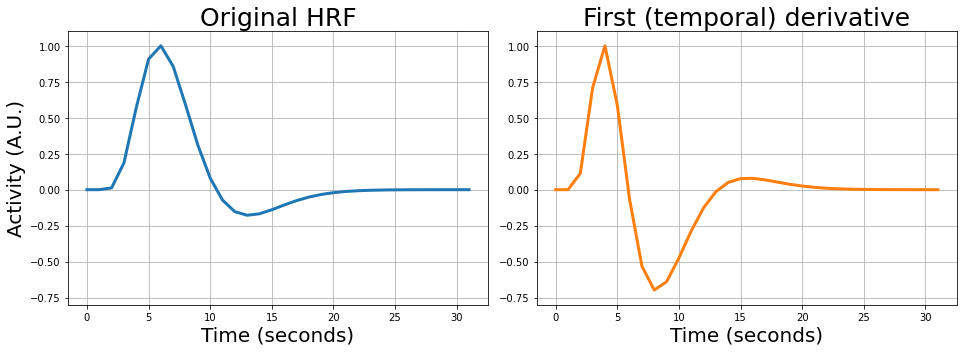

In [78]:
from nilearn.glm.first_level.hemodynamic_models import glover_time_derivative

tderiv_hrf = glover_time_derivative(tr=2, oversampling=2)
tderiv_hrf /= tderiv_hrf.max()

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(canonical_hrf, lw=3)
plt.ylim(-0.8, 1.1)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.xlabel("Time (seconds)", fontsize=20)
plt.title("Original HRF", fontsize=25)
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(tderiv_hrf, c='tab:orange', lw=3)
plt.ylim(-0.8, 1.1)
plt.xlabel("Time (seconds)", fontsize=20)
plt.title("First (temporal) derivative", fontsize=25)

plt.tight_layout()
plt.grid()

plt.show()

The cool thing about this double-gamma basis set is that the derivatives can (to a certain extent) correct for slight deviations in the lag and shape of the HRF based on the data! Specifically, the first (temporal) derivative can correct for slight differences in lag (compared to the canonical single-gamma HRF) and the second (dispersion) derivative can correct for slight difference in the width (or "dispersion") of the HRF (compared to the canonical single-gamma HRF). 

"How does this 'correction' work, then?", you might ask. Well, think about it this way: the original (canonical) HRF measures the increase/decrease &mdash; or amplitude &mdash; of the BOLD-response. In a similar way, the temporal derivative measures the *onset* &mdash; or lag &mdash; of the BOLD-response. (And if you use the dispersion derivative: this would measure the *width* of the BOLD-response.) 

When we use our two predictors (one convolved with the canonical HRF, one with the temporal derivative) in a linear regression model, the model will assign each predictor (each part of the HRF) a beta-weight, as you know. These beta-weights are chosen such that model the data &mdash; some response of the voxel to a stimulus &mdash; as well as possible. Basically, assigning a (relatively) high (positive or negative) beta-weight to the predictor convolved with the temporal derivative will "shift" the HRF (increases/decreases the onset of the HRF).

Alright, let's visualize this. Suppose we have a voxel that we know does not conform to the specific assumptions about lag (onset) of the canonical (double-gamma) HRF. Specifically, we see that the canonical HRF peaks too early.
We'll show below that it suboptimally explains this voxel.

First we'll create af function that can simulate some data. You need to run this, but do not need to care about the details.

In [79]:
def simulate_signal(onsets, conditions, TR=2, duration=None, icept=0, params_canon=None, params_tderiv=None,
                    params_deriv1=None, phi=None, std_noise=1, osf=100, rnd_seed=None, plot=True):
    """ Simulates a somewhat realistic voxel signal with an associated design matrix. """
    if rnd_seed is not None:
        np.random.seed(rnd_seed)
    
    conds = sorted(np.unique(conditions))
    P = len(conds)
    
    if duration is None:
        duration = np.max(onsets) + 30
    
    if params_canon is None:
        params_canon = np.zeros(P)

    # TMP FIX
    params_tderiv = params_deriv1
    
    if params_tderiv is None:
        params_tderiv = np.zeros(P)

    X = np.zeros((duration * osf, P))
    for ons, con in zip(onsets, conditions):
        X[int(ons * osf), conds.index(con)] = 1
        
    hrf = glover_hrf(tr=1, oversampling=osf)
    hrf_d = glover_time_derivative(tr=1, oversampling=osf)

    t_orig = np.arange(0, duration, 1 / osf)
    t_new = np.arange(0, duration, TR)
    
    Xconv = np.zeros((t_orig.size, P * 2))
    idx = 0
    for i, this_hrf in enumerate([hrf, hrf_d]):
        this_hrf /= this_hrf.max()
        for ii in range(P):
            Xconv[:, idx] = np.convolve(X[:, ii], this_hrf)[:t_orig.size]  
            idx += 1
    
    Xconv = np.c_[np.ones(Xconv.shape[0]), Xconv]
    params = np.r_[icept, params_canon, params_tderiv]
    y = Xconv @ params
    
    resampler = interp1d(t_orig, y)
    y = resampler(t_new)       
    
    if phi is None:
        noise_cov = std_noise ** 2 * np.eye(y.size)
    else:
        noise_cov = std_noise ** 2 * phi ** toeplitz(np.arange(y.size))
    
    y = y + np.random.multivariate_normal(np.zeros(y.size), noise_cov)

    Xconv_ds = np.zeros((t_new.size, Xconv.shape[1]))
    for i in range(Xconv.shape[1]):
        resampler = interp1d(t_orig, Xconv[:, i])
        Xconv_ds[:, i] = resampler(t_new)
    
    est_betas = np.linalg.lstsq(Xconv_ds, y, rcond=None)[0]
    if plot:
        plt.figure(figsize=(15, 5))
        plt.plot(y)
        plt.plot(Xconv_ds @ est_betas)
        plt.xlim(0, y.size)
        plt.legend(['y', 'y-hat'])
        plt.show()

    return y, Xconv_ds



Now, lets use the function and simulate some data for display purposes:

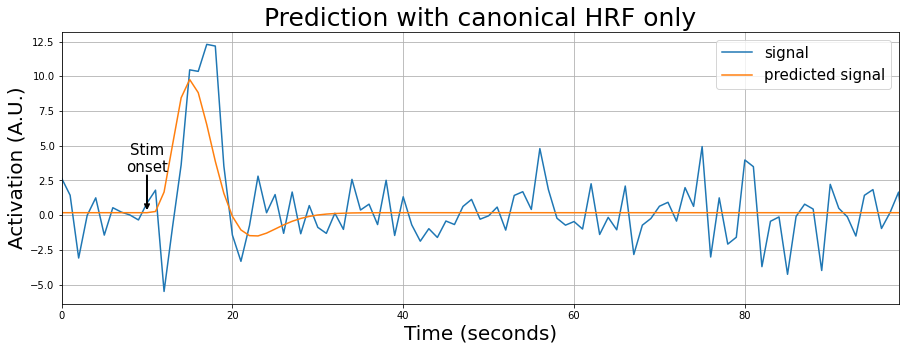

In [80]:
#This uses the function above to generate data and model

# tbs = temporal basis set
y_tbs, X_tbs = simulate_signal(
    onsets=[10],
    conditions=['stim'],
    duration=100,
    TR=1,
    icept=0,
    params_canon=[10],
    params_deriv1=[-8],
    std_noise=2,
    rnd_seed=10,
    plot=False
)

X_canon_only = X_tbs[:, :-1]  # remove temporal derivative for now

# Do regression 
beta_canon = inv(X_canon_only.T @ X_canon_only) @ X_canon_only.T @ y_tbs
yhat_canon = X_canon_only @ beta_canon

# Plot the data and the prediction (y_hat)
plt.figure(figsize=(15, 5))
plt.plot(y_tbs)
plt.plot(yhat_canon)
plt.xlim(0, 98)
plt.xlabel("Time (seconds)", fontsize=20)
plt.ylabel("Activation (A.U.)", fontsize=20)
plt.annotate('', xy=(10, 3), xytext=(10, 0.2),
             arrowprops=dict(arrowstyle='<-', lw=2))
plt.text(10, 3.1, 'Stim\nonset', horizontalalignment='center', fontsize=15)
plt.legend(['signal', 'predicted signal'], fontsize=15)
plt.title("Prediction with canonical HRF only", fontsize=25)
plt.grid()
plt.show()

As you can see, the predicted signal (orange line) misses the peak of the BOLD-response. Now, let's see what happens if we add the temporal derivative to the model:

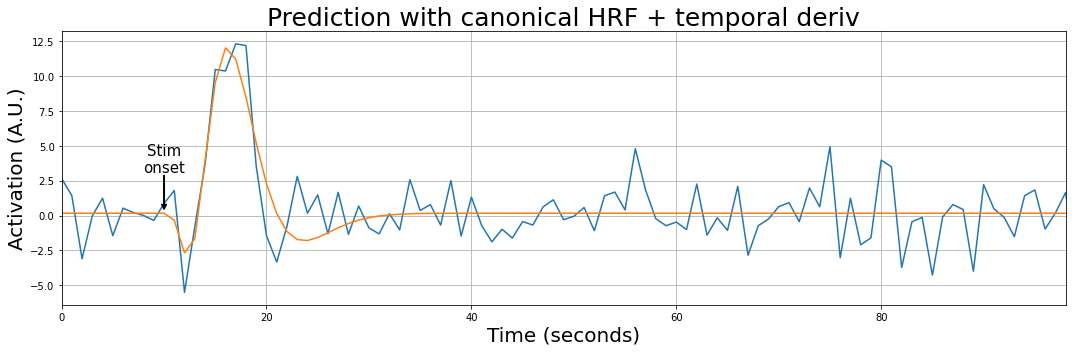

In [81]:
# Do regression with HRF + temp deriv HRF
beta_td = inv(X_tbs.T @ X_tbs) @ X_tbs.T @ y_tbs
yhat_td = X_tbs @ beta_td

# Plot model with temp deriv HRF
plt.figure(figsize=(15, 5))
plt.plot(y_tbs)
plt.plot(yhat_td)
plt.xlim(0, 98)
plt.ylabel("Activation (A.U.)", fontsize=20)
plt.annotate('', xy=(10, 3), xytext=(10, 0.2),
             arrowprops=dict(arrowstyle='<-', lw=2))
plt.text(10, 3.1, 'Stim\nonset', horizontalalignment='center', fontsize=15)
plt.title("Prediction with canonical HRF + temporal deriv", fontsize=25)
plt.xlabel("Time (seconds)", fontsize=20)

plt.grid()

plt.tight_layout()
plt.show()

As you can see, the prediction improves quite a bit when including the temporal derivative! But how should we interpret the beta-parameters? Well, usually people don't really interpret the temporal (and dispersion derivative) HRFs (unless they're interested in lag/width of the HRF), because most researchers are interesting in the activation/deactivation (the amplitude) of voxels in response to a stimulus, which corresponds to the beta-parameters associated with the canonical HRF. So, basically, the temporal (and dispersion) derivative(s) are mainly used to "correct" for deviations in terms of lag/shape from the canonical HRF!

So, should you then always use a (gamma) basis set? People are quite divided on the topic of whether to use basis sets or a canonical HRF. In our experience, derivatives (e.g. in the gamma basis sets) offer little improvement over a canonical HRF in simple group-level analyses (in which you average over many participants; the topic of later tutorials), but it doesn't hurt either (given that you have "enough" degrees of freedom).


<b>All together now</b>:
    
Let's reanalyze the voxel signal with the separate conditions (like in ToDo4), but this time with a both the canonical HRF (<tt>canonical_hrf</tt>) and the associated temporal derivative. We can use the variable <tt>tderiv_hrf</tt>)! 

We'll calculate the beta-parameters for the voxel signal (i.e., the variable <tt>voxel_signal</tt>), MSE, and $R^2$ and store the MSE in a variable named <tt>mse_gbf</tt> and $R^2$ in a variable named <tt>r2_gbf</tt>. 

We will implement this in "steps", such that we can test intermediate output:
1. Convolve the circle predictor (<tt>predictor_circles</tt>) and the squares predictor (<tt>predictor_squares</tt>) with the two HRF basis functions (canonical, temporal deriv.) separately, giving you 4 predictors, stack them together and add an intercept (make sure the intercept is the first column). Then, downsample your design matrix to the scale of you voxel signal. Store your downsampled design matrix in a variable named <tt>X_gbf</tt>; Note: the order of the columns should be: intercept, circles (canonical), circles (temp. deriv.), squares (canonical), squares (temp. deriv.). If you don't do this, automatic grading will fail and you won't get any points; (2 points)
2. Run linear regression (your DV is the variable <tt>voxel_signal</tt>) and store your betas in a variable named <tt>betas_gbf</tt>; (1 point)
3. Calculate R-squared and store it in a variable named <tt>r2_gbf</tt>; (1 point)
4. Calculate MSE and store it in a variable named <tt>mse_gbf</tt>; (1 point)



In [82]:
# Step 1: convolve the predictors (and let's not forget to trim and downsample)!

# We'll start with the binary predictors
predictor_circles = np.zeros(800)
predictor_circles[onsets_circles] = 1

predictor_squares = np.zeros(800)
predictor_squares[onsets_squares] = 1

# Convolving each predictor with the HRF and the temporal derivative
pred_ci_conv1 = np.convolve(predictor_circles, canonical_hrf)[:800][:, np.newaxis]
pred_ci_conv2 = np.convolve(predictor_circles, tderiv_hrf)[:800][:, np.newaxis]
pred_sq_conv1 = np.convolve(predictor_squares, canonical_hrf)[:800][:, np.newaxis]
pred_sq_conv2 = np.convolve(predictor_squares, tderiv_hrf)[:800][:, np.newaxis]
# Create an intercept vector
icept = np.ones((800, 1))

# Put it all into a design matrix
X_gbf_up = np.hstack((
    icept, pred_ci_conv1, pred_ci_conv2,
    pred_sq_conv1, pred_sq_conv2,
))

print("Size of design matrix before downsampling:", X_gbf_up.shape)

# Create time vectors to use for interpolation
t_orig = np.arange(0, 800, 1)
t_new = np.arange(0, 800, 2)

#Initialise a matrix with zeros 
X_gbf = np.zeros((400, X_gbf_up.shape[1]))

#Down-sample to new resolution. Only run to the new length (i.e. trim)
for i in range(X_gbf.shape[1]):
    resampler = interp1d(t_orig, X_gbf_up[:, i])
    X_gbf[:, i] = resampler(t_new) 

print("Size of design matrix after downsampling:", X_gbf.shape)

Size of design matrix before downsampling: (800, 5)
Size of design matrix after downsampling: (400, 5)


In [83]:
# Step 2: run linear regression

betas_gbf = inv(X_gbf.T @ X_gbf) @ X_gbf.T @ voxel_signal
print("Betas:",betas_gbf)

Betas: [1.00012988e+03 9.42126061e+00 6.49539593e+00 6.70646028e+00
 5.30134498e-01]


In [84]:
# Step 3: calculate R-squared (and store it in a variable named r2_gbf)


y_hat_gbf = X_gbf @ betas_gbf
r2_gbf = 1 - (np.sum((voxel_signal - y_hat_gbf) ** 2) / np.sum((voxel_signal - voxel_signal.mean()) ** 2))
print("R-squared:", r2_gbf)

R-squared: 0.5770552048362486


In [85]:
# Step 4: calculate MSE (and store it in a variable named mse_gbf)

mse_gbf = np.mean((voxel_signal - y_hat_gbf) ** 2)

print("Mean squared error: ", mse_gbf)

Mean squared error:  4.38491393711736


From what we've showed so far, hopefully, you noticed that how linear regression is applied to model a voxel signal is not that much different from 'regular' data, except for the convolution/HRF part. At this moment, you already know 95% of how univariate analysis works! There are, however, still a couple of concepts we need to address, which we'll cover that in the next tutorial: statistical inference of model parameters.

## SOLUTIONS

<div class='alert alert-info'>
<b>Solution for ToThink1</b> :
</div>

400 measurements x 2 s (TR)= 800 s

<div class='alert alert-warning'><b>Solution to ToDo1</b>:
</div>

In [46]:
# Create onsets
onsets2 = np.array([12, 24, 33, 42], dtype=int)

# First create pred2
pred2 = np.zeros(60)
pred2[onsets2] = 1
original_scale = np.arange(0, 60, 1)

# Then downsample it to create pred2_ds
resampler = interp1d(original_scale, pred2)
desired_scale = np.arange(0, 60, 3)
pred2_ds = resampler(desired_scale)


<div class='alert alert-info'>
<b>Solution to ToThink2</b>:
</div>

Solution to ToThink2: Because the BOLD-response is so slow, it cannot distinguish between short consecutive stimuli and one longer stimulus (which is evident by the fact that after convolution of these two hypothetical stimulus-vectors, they look identical).

<div class='alert alert-warning'>
    <b>Solution for ToDo2</b>: 
</div>

In [47]:
### BEGIN SOLUTION FOR ToDo2:
todo_pred = np.zeros(3 * 60)
for ons in [0, 30, 60, 90, 120, 150]:
    todo_pred[ons:(ons + 20)] = 1
todo_pred_conv = np.convolve(todo_pred, canonical_hrf)[:todo_pred.size]
### END SOLUTION

<div class='alert alert-warning'>
    <b>Solution for ToDo3</b>:
</div>

In [48]:
# Implement your ToDo3 here
original_scale = np.arange(0, duration, 0.01)  # in steps of 0.01 seconds, i.e., hundredths of seconds

### BEGIN SOLUTION
TR = 1.25
resampler = interp1d(original_scale, pred2_conv)
desired_scale = np.arange(0, 50, TR)
pred2_conv_ds = resampler(desired_scale)
### END SOLUTION

<div class='alert alert-warning'>
<b>Solution for ToDo4</b>:

</div>

In [49]:
predictor_circles = np.zeros((800, 1))
predictor_circles[onsets_circles] = 1

predictor_squares = np.zeros((800, 1))
predictor_squares[onsets_squares] = 1


### BEGIN SOLUTION
pred_circ_conv = np.convolve(predictor_circles.squeeze(), canonical_hrf)[:800][:, np.newaxis]
pred_squar_conv = np.convolve(predictor_squares.squeeze(), canonical_hrf)[:800][:, np.newaxis]

original_scale = np.arange(0, 800, 1)
desired_scale = np.arange(0, 800, 2)  # given a TR of 2

resampler = interp1d(original_scale, pred_circ_conv.squeeze())
pred_circ_conv = resampler(desired_scale)

resampler = interp1d(original_scale, pred_squar_conv.squeeze())
pred_squar_conv = resampler(desired_scale)

X_new = np.hstack((np.ones((400, 1)), pred_circ_conv[:, np.newaxis], pred_squar_conv[:, np.newaxis]))
b_new = inv(X_new.T @ X_new) @ X_new.T @ voxel_signal
y_hat_new = X_new @ b_new
mse_new = np.mean((y_hat_new - voxel_signal) ** 2)
r2_new = 1 - (np.sum((y_hat_new - voxel_signal) ** 2) / np.sum((voxel_signal.mean() - voxel_signal) ** 2))

print("R-squared of new model", r2_new)
### END SOLUTION

R-squared of new model 0.3090643604897927


<div class='alert alert-info'>
<b>Solution to ToThink3</b>:
</div>

Because with separate predictors, the model can assign different effects to the two predictors. If the two conditions would in fact have a different effect on the voxel, then this would be impossible to model in the lumped-together scenario, because this model can only explain a "common" effect of the conditions.

Using two separate regressors also increases the chances of overfitting. When doing inferential statistics, we would pay a penality for this by removing one degree of freedom.